Hastane 1 (Klinik) Sütunları: ['gender', 'age', 'hypertension']...
Hastane 2 (Lab) Sütunları: ['Pregnancies', 'Glucose', 'BloodPressure']...
Hastane 3 (Anket) Sütunları: ['HighBP', 'HighChol', 'CholCheck']...
Model 1 (Klinik Uzmanı) Eğitildi.
Model 2 (Lab Uzmanı) Eğitildi.
Model 3 (Yaşam Tarzı Uzmanı) Eğitildi.


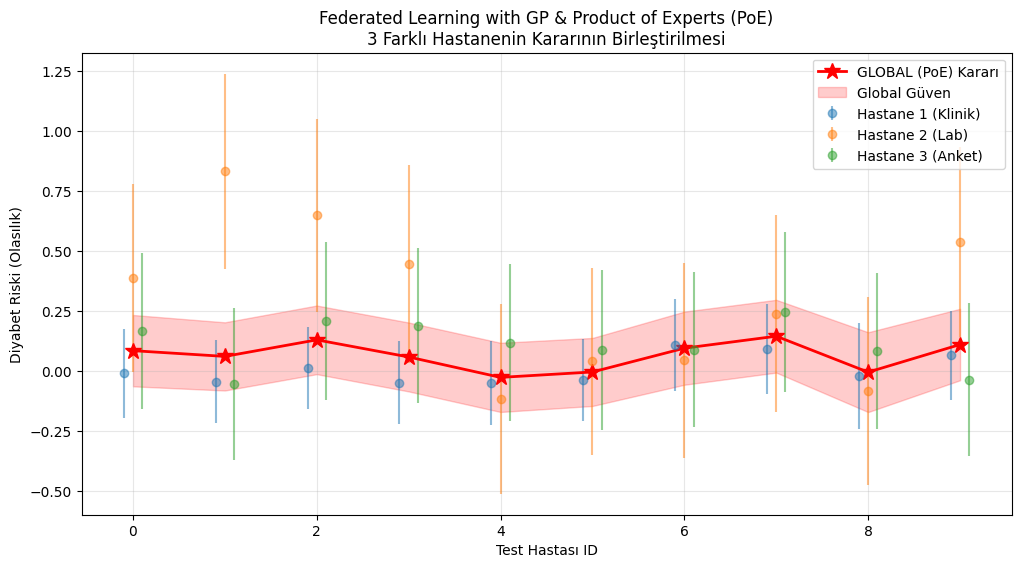

In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- 1. VERİ YÜKLEME VE ÖN İŞLEME ---

# Verileri yükle
df1 = pd.read_csv('diabetes_1.csv')
df2 = pd.read_csv('diabetes_2.csv')
df3 = pd.read_csv('diabetes_3.csv')

# GP çok veriyle yavaş çalışır, prototip için veriyi küçültelim (Sampling)
# Gerçek projede SparseGP kullanırsın, şimdilik standart GP ile simüle ediyoruz.
SAMPLE_SIZE = 500
df1 = df1.sample(n=SAMPLE_SIZE, random_state=42)
df2 = df2.sample(n=SAMPLE_SIZE, random_state=42)
df3 = df3.sample(n=SAMPLE_SIZE, random_state=42)

# Ön İşleme Fonksiyonu (Local Preprocessing)
def preprocess_data(df, target_col):
    df = df.copy()

    # Kategorik verileri sayıya çevir (Label Encoding)
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col].astype(str))

    # Hedef ve Girdi ayrımı
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # GP için Scale etmek şarttır
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y.values, scaler, list(X.columns)

# Her hastane kendi verisini temizler
# df3'te Outcome 'Diabetes_012' idi, onu 0/1 yapalım
df3['Outcome'] = df3['Diabetes_012'].apply(lambda x: 1 if x > 0 else 0)
df3 = df3.drop(columns=['Diabetes_012'])

X1, y1, scaler1, cols1 = preprocess_data(df1, 'diabetes')
X2, y2, scaler2, cols2 = preprocess_data(df2, 'Outcome')
X3, y3, scaler3, cols3 = preprocess_data(df3, 'Outcome')

print(f"Hastane 1 (Klinik) Sütunları: {cols1[:3]}...")
print(f"Hastane 2 (Lab) Sütunları: {cols2[:3]}...")
print(f"Hastane 3 (Anket) Sütunları: {cols3[:3]}...")

# --- 2. YEREL EĞİTİM (LOCAL TRAINING) ---
# Federated Learning Aşaması: Herkes evinde çalışıyor

kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)

# Model 1
gp1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, random_state=0)
gp1.fit(X1, y1)
print("Model 1 (Klinik Uzmanı) Eğitildi.")

# Model 2
gp2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, random_state=1)
gp2.fit(X2, y2)
print("Model 2 (Lab Uzmanı) Eğitildi.")

# Model 3
gp3 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, random_state=2)
gp3.fit(X3, y3)
print("Model 3 (Yaşam Tarzı Uzmanı) Eğitildi.")

# --- 3. GLOBAL BİRLEŞTİRME (PoE INFERENCE) ---
# Senaryo: Kapıdan yeni bir hasta girdi. 3 hastaneye de verisi yollandı.

def product_of_experts(means, stds):
    """
    3 Farklı modelden gelen Mean ve Std değerlerini birleştirir.
    Formül: Precision-weighted averaging.
    """
    variances = stds**2
    precisions = 1.0 / (variances + 1e-8) # 0'a bölme hatası olmasın

    # Global Precision = Toplam Precision
    global_precision = np.sum(precisions, axis=0)
    global_variance = 1.0 / global_precision
    global_std = np.sqrt(global_variance)

    # Global Mean = Ağırlıklı Ortalama
    # (P1*M1 + P2*M2 + P3*M3) / P_total
    weighted_means = np.sum(precisions * means, axis=0)
    global_mean = global_variance * weighted_means

    return global_mean, global_std

# Test için rastgele 10 hasta seçelim (Simülasyon)
# Gerçek hayatta bu hasta tek bir kişidir ve 3 hastaneye de verisi gider.
# Biz burada simülasyon yaptığımız için X1, X2 ve X3'ten rastgele örnekler alıp "Bu aynı kişi" diyeceğiz.
test_indices = np.random.choice(len(X1), 10, replace=False) # Rastgele 10 kişi

# Tahminleri topla
mu1, std1 = gp1.predict(X1[test_indices], return_std=True)
mu2, std2 = gp2.predict(X2[test_indices], return_std=True) # X2'den de rastgele alıyoruz simülasyon için
mu3, std3 = gp3.predict(X3[test_indices], return_std=True)

# Birleştirme Anı!
means_matrix = np.array([mu1, mu2, mu3])
stds_matrix = np.array([std1, std2, std3])

global_mu, global_std = product_of_experts(means_matrix, stds_matrix)

# --- 4. SONUÇLARI GÖRSELLEŞTİR ---
plt.figure(figsize=(12, 6))
x_axis = np.arange(10) # 10 Hasta

# Bireysel Tahminler
plt.errorbar(x_axis - 0.1, mu1, yerr=std1, fmt='o', label='Data 1', alpha=0.5)
plt.errorbar(x_axis, mu2, yerr=std2, fmt='o', label='Data 2', alpha=0.5)
plt.errorbar(x_axis + 0.1, mu3, yerr=std3, fmt='o', label='Data 3', alpha=0.5)

# GLOBAL PoE Tahmini (Daha koyu ve belirgin)
plt.plot(x_axis, global_mu, 'r*-', markersize=12, linewidth=2, label='GLOBAL (PoE) DEcision')
plt.fill_between(x_axis, global_mu - global_std, global_mu + global_std, color='red', alpha=0.2, label='Global Güven')

plt.title("Federated Learning with GP & Product of Experts (PoE)\n3 Farklı Hastanenin Kararının Birleştirilmesi")
plt.xlabel("Test Hastası ID")
plt.ylabel("Diyabet Riski (Olasılık)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('federated_poe_result.png')